# Comparison of the supervised models
    All the hyperparmeters values were entered below.
    The data was scaled.
    The AUC/ROC was calculated.
    The Accuracy was calculated for each.
    The best model was picked and the Recall and Prcision was calculated.
    The feature importance was also calculated.

    1.) Random Forest
    2.) Random Forest ADA Boost
    3.) Extreme Gradient Boost

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import math

from pandas.tools.plotting import scatter_matrix
import matplotlib.pyplot as plt
from time import time
from IPython.display import display
from sklearn import model_selection
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn import ensemble
from sklearn.pipeline import Pipeline

from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
#from sklearn.svm import SVC
#from sklearn.preprocessing import StandardScaler
#from sklearn.decomposition import PCA

from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from xgboost import plot_importance

from sklearn.metrics import mean_squared_error
sns.set(style="darkgrid")


%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('lending_club_le.csv', index_col=0)
y = df['good_loan_status']
X = df.drop(['good_loan_status'], axis=1)

In [3]:
X.shape, y.shape

((87923, 41), (87923,))

In [4]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42)

In [5]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((70338, 41), (17585, 41), (70338,), (17585,))

------

# Model comparison of accuracy score

These are the tuned values from the previous notebook

In [6]:
rf_final = ensemble.RandomForestClassifier(bootstrap=True,
                                           max_depth=8,
                                           max_features=10,
                                           min_samples_leaf=50,
                                           min_samples_split=60,
                                           n_estimators=20)

In [7]:
# Let's see the accuracy scores for all of our models.
models = []
results = []
names = []
print('\t   Accuracy\n\t score\t  std')


models.append(('RFC',
               ensemble.RandomForestClassifier(bootstrap=True,
                                           max_depth=8,
                                           max_features=10,
                                           min_samples_leaf=50,
                                           min_samples_split=60,
                                           n_estimators=20)))

models.append(('ADA',
               AdaBoostClassifier(base_estimator=rf_final,
                                  n_estimators=14)))

models.append(('XGB',
               XGBClassifier(max_depth=6,
                             n_estimators=8,
                             learning_rate=0.0125,
                             subsample=0.03,
                             colsample_bytree=0.5,
                             colsample_bylevel=0.5)))

for name, model in models:
    kfold = model_selection.KFold(n_splits=3, random_state=42)
    cv_results = model_selection.cross_val_score(model,
                                                 X_train,
                                                 y_train,
                                                 cv=5,
                                                 scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s:\t%.4f (%.4f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
print('----------------------------------------------------------\n')
for name, model in models:
    model.fit(X_train, y_train)
    y_pred2 = model.predict(X_test)
    names.append(name)

    print('\n', name, '\nconfusion matrix \n',
          confusion_matrix(y_test, y_pred2))
    print('\nholdout accuracy score: ', accuracy_score(y_test, y_pred2))
    print('\ncross validation scores: ',
          cross_val_score(model, X_test, y_test, cv=5))
    print('\n', classification_report(y_test, y_pred2))
    print('----------------------------------------------------------\n')

    mse = math.sqrt(mean_squared_error(y_test, y_pred2))
    print("MSE: %.4f RMSE: %.4f" % (mse, np.sqrt(mse)))
    print('----------------------------------------------------------\n')

	   Accuracy
	 score	  std
RFC:	0.7522 (0.0013)
ADA:	0.7614 (0.0020)
XGB:	0.7494 (0.0005)
----------------------------------------------------------


 RFC 
confusion matrix 
 [[   93  4363]
 [   36 13093]]

holdout accuracy score:  0.7498436167187944

cross validation scores:  [0.75099488 0.74751208 0.74808075 0.74921808 0.75085324]

               precision    recall  f1-score   support

           0       0.72      0.02      0.04      4456
           1       0.75      1.00      0.86     13129

   micro avg       0.75      0.75      0.75     17585
   macro avg       0.74      0.51      0.45     17585
weighted avg       0.74      0.75      0.65     17585

----------------------------------------------------------

MSE: 0.5002 RMSE: 0.7072
----------------------------------------------------------


 ADA 
confusion matrix 
 [[  779  3677]
 [  486 12643]]

holdout accuracy score:  0.7632641455786181

cross validation scores:  [0.75696418 0.75831675 0.75007108 0.75916975 0.75142207]

   

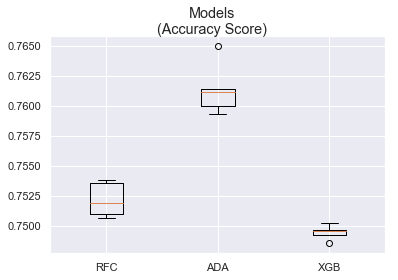

In [8]:
# Let's take a look at the Accuracy scores on a box plot
fig = plt.figure()
sns.set(style="darkgrid")
fig.suptitle('Models\n(Accuracy Score)')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Accuracy score summary

_The RFC model has a holdout score of `~75%`.  It is able to accuracy predict good loan applications 75% of the time. XGB predicts a little better than the baseline `74.83%`.  The cross validation scores for the RFC & XGB models are stable as we also see in the plot. All models predict many more false positives than false negatives, which is a good thing. The model should predict more `True Positives` than `False Negatives`._

_Recall is the ratio of correctly predicted positive observations to the all observations in actual class. The question recall answers is: Of all the loans that are truly good, how many did the model label correctly? RFC has a recall of ~100% but we will discuss this further after we calculate the ROC scores._

_Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. The question that this metric answers is of all loans that are labeled as good, how many actually were good? The RFC model has a ~75% precision, which is pretty good._

----

# Model comparison of ROC-AUC score

In [9]:
# ROC-AUC scores for all of our models.
print('\t   ROC/AUC\n\t score\t  std')
results = []
names = []
names1 = []
models = []

models.append(('RFC',
               ensemble.RandomForestClassifier(bootstrap=True,
                                               max_depth=8,
                                               max_features=10,
                                               min_samples_leaf=50,
                                               min_samples_split=60,
                                               n_estimators=20)))

models.append(('ADA',
               AdaBoostClassifier(base_estimator=rf_final,
                                  n_estimators=14)))

models.append(('XGB',
               XGBClassifier(max_depth=6,
                             n_estimators=8,
                             learning_rate=0.0125,
                             subsample=0.03,
                             colsample_bytree=0.5,
                             colsample_bylevel=0.5)))


for name, model in models:
    kfold = model_selection.KFold(n_splits=3, random_state=42)
    cv_results = model_selection.cross_val_score(model,
                                                 X_train,
                                                 y_train,
                                                 cv=5,
                                                 scoring='roc_auc')
    results.append(cv_results)
    names.append(name)
    msg = "%s:\t%.4f (%.4f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
print('----------------------------------------------------------\n')

for name1, model1 in models:
    model1.fit(X_train, y_train)
    y_pred2 = model1.predict(X_test)
    names1.append(name1)
    print('\n', name1, '\nconfusion matrix \n',
          confusion_matrix(y_test, y_pred2))
    print('\nholdout accuracy score: ', accuracy_score(y_test, y_pred2))
    print('\ncross validation scores: ',
          cross_val_score(model1, X_test, y_test, cv=5))
    print('\n', classification_report(y_test, y_pred2))
    print('----------------------------------------------------------\n')

	   ROC/AUC
	 score	  std
RFC:	0.6952 (0.0064)
ADA:	0.7224 (0.0045)
XGB:	0.6527 (0.0075)
----------------------------------------------------------


 RFC 
confusion matrix 
 [[  123  4333]
 [   53 13076]]

holdout accuracy score:  0.750582883139039

cross validation scores:  [0.74928937 0.74808075 0.75035542 0.75063975 0.75056883]

               precision    recall  f1-score   support

           0       0.70      0.03      0.05      4456
           1       0.75      1.00      0.86     13129

   micro avg       0.75      0.75      0.75     17585
   macro avg       0.72      0.51      0.45     17585
weighted avg       0.74      0.75      0.65     17585

----------------------------------------------------------


 ADA 
confusion matrix 
 [[  776  3680]
 [  527 12602]]

holdout accuracy score:  0.760762013079329

cross validation scores:  [0.75184764 0.75433608 0.75149275 0.75973841 0.75540387]

               precision    recall  f1-score   support

           0       0.60      0.17  

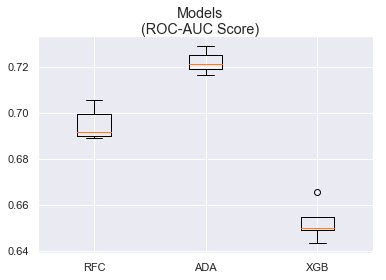

In [10]:
# Let's take a look at these ROC-AUC scores on a box plot
plt.rcParams['font.size'] = 12
fig = plt.figure()
fig.suptitle('Models\n(ROC-AUC Score)')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

_Now looking at the ROC scores, XGB has the better recall score but has the lowest ROC score.  ADABoost can identify good loans, which means it also has a high recall score. But I would still stick with RFC becasue it also has a high ROC score, accuracy score and high recall._

----

----

# Random Forest Evaluation 

    - ROC curve plot
    - confusion matrix
    - F1Score
    - Feature importance

In [11]:
rf_final.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=60,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

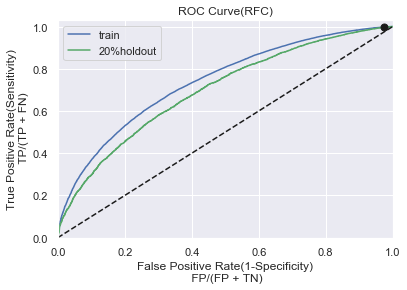

In [12]:
rf_confmtx = confusion_matrix(y_test, rf_final.predict(X_test))
tn, fp, fn, tp = [i for i in rf_confmtx.ravel()]

ypred_train = rf_final.predict_proba(X_train)[:, 1]
ypred_test = rf_final.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_train, ypred_train)
fpr1, tpr1, thresholds = roc_curve(y_test, ypred_test)
x = fp/(fp+tn)
y = tp/(tp+fn)

plt.plot(fpr, tpr, color='b')
plt.plot(fpr1, tpr1, color='g', label="20%holdout")
plt.plot(x, y, 'ko', markersize=7)
plt.legend(['train', '20%holdout'])
plt.title('ROC Curve(RFC)')
plt.xlabel('False Positive Rate(1-Specificity)\n FP/(FP + TN)')
plt.ylabel('True Positive Rate(Sensitivity)\n TP/(TP + FN)')
plt.xlim([0.0, 1])
plt.ylim([0.0, 1.03])
plt.grid(True)
plt.plot([0, 1], [0, 1], 'k--')
# plt.tight_layout()
plt.show()

Precision:	0.7508
Recall:		0.9960
F1 Score:	0.8562


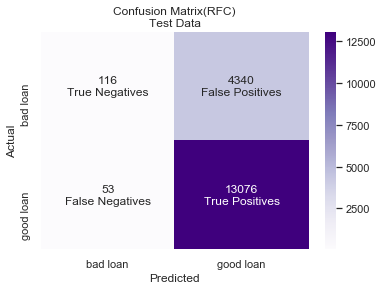

In [13]:
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2*(precision * recall) / (precision + recall)
print('Precision:\t{:.4f}\nRecall:\t\t{:.4f}\nF1 Score:\t{:.4}'.format(
    precision, recall, f1))


plt.rcParams['font.size'] = 12
plt.subplot(111)
ax = sns.heatmap(rf_confmtx, annot=True, cmap='Purples',
                 annot_kws={"size": 12}, fmt='g')
labels = ['True Negatives', 'False Positives',
          'False Negatives', 'True Positives']
for k, v in enumerate(ax.texts):
    v.set_text(v.get_text() + "\n" + labels[k])
plt.title('Confusion Matrix(RFC)\nTest Data')
ax.xaxis.set_ticklabels(['bad loan', 'good loan'])
ax.yaxis.set_ticklabels(['bad loan', 'good loan'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### RF Final Results
Of the `13,129` positive loans, Random Forest was able to predict `13,088` good loan applications, that is a good recall of `99.69%`. Even though the accuracy score is `75%` the recall is `99.69%`.

___Random Forest Feature Importance___

In [14]:
headers = ["feature", "score"]
values = sorted(
    zip(X_train.columns, rf_final.feature_importances_), key=lambda x: x[1] * -1)
dfFeat = pd.DataFrame(np.array(values), columns=list(headers))
dfFeat.head(10)

,feature,score
0,loan_amnt,0.2093057860472146
1,tot_hi_cred_lim,0.1604216091300385
2,dti,0.06311814268400848
3,home_ownership,0.0584740810796603
4,verification_status,0.05198718318301887
5,mths_since_recent_inq,0.03833467388548363
6,percent_bc_gt_75,0.03466248732476949
7,all_util,0.03288365145483101
8,mo_sin_old_rev_tl_op,0.03168393749000069
9,revol_util,0.029829066811027267


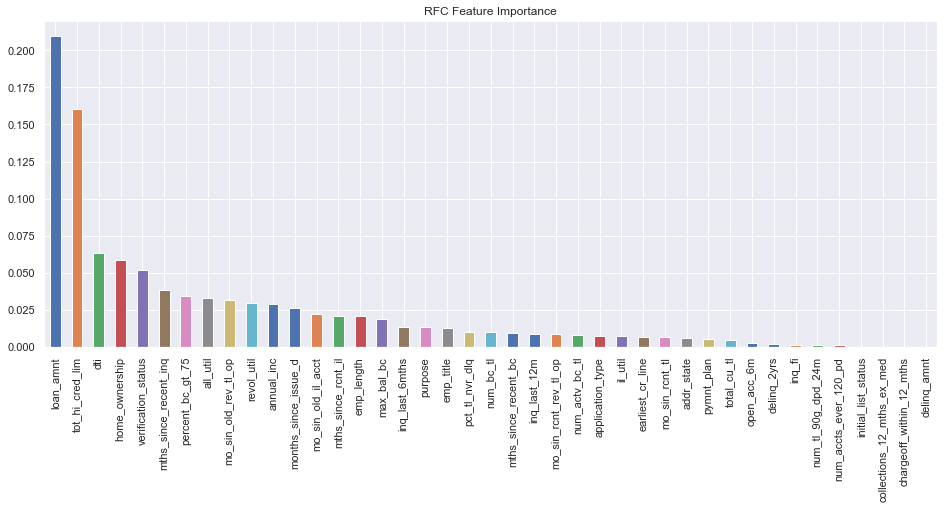

In [29]:
plt.figure(figsize=(16, 6))
plt.title('RFC Feature Importance')

feat_importances = pd.Series(
    rf_final.feature_importances_, index=X_train.columns)
feat_importances.nlargest(41).plot(kind='bar')

In [16]:
feat_importances.nlargest(10)

loan_amnt                0.209306
tot_hi_cred_lim          0.160422
dti                      0.063118
home_ownership           0.058474
verification_status      0.051987
mths_since_recent_inq    0.038335
percent_bc_gt_75         0.034662
all_util                 0.032884
mo_sin_old_rev_tl_op     0.031684
revol_util               0.029829
dtype: float64

# Random Forest with ADABoost Evaluation 

    - ROC curve plot
    - confusion matrix
    - F1Score
    - Feature importance

In [17]:
ada_final = AdaBoostClassifier(base_estimator=rf_final,
                               n_estimators=14)

In [18]:
ada_final.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=60,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          learning_rate=1.0, n_estimators=14, random_state=None)

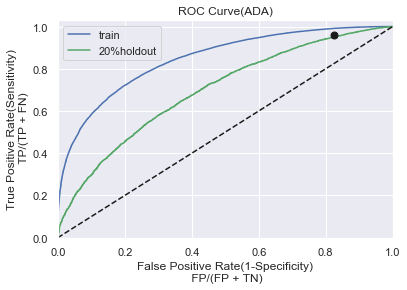

In [19]:
ada_confmtx = confusion_matrix(y_test, ada_final.predict(X_test))
tn2, fp2, fn2, tp2 = [i for i in ada_confmtx.ravel()]


ypred_train = ada_final.predict_proba(X_train)[:, 1]
ypred_test = ada_final.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_train, ypred_train)
fpr2, tpr2, thresholds = roc_curve(y_test, ypred_test)
x2 = fp2/(fp2+tn2)
y2 = tp2/(tp2+fn2)
plt.plot(fpr, tpr, color='b')
plt.plot(fpr1, tpr1, color='g', label="20%holdout")
plt.plot(x2, y2, 'ko', markersize=7)
plt.legend(['train', '20%holdout'])
plt.title('ROC Curve(ADA)')
plt.xlabel('False Positive Rate(1-Specificity)\n FP/(FP + TN)')
plt.ylabel('True Positive Rate(Sensitivity)\n TP/(TP + FN)')
plt.xlim([0.0, 1])
plt.ylim([0.0, 1.03])
plt.grid(True)
plt.plot([0, 1], [0, 1], 'k--')
# plt.tight_layout()
plt.show()

Precision:	0.7741
Recall:		0.9597
F1 Score:	0.8569


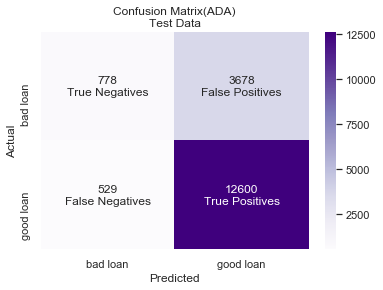

In [20]:
precision_ada = tp2 / (tp2 + fp2)
recall_ada = tp2 / (tp2 + fn2)
f1_ada = 2*(precision_ada * recall_ada) / (precision_ada + recall_ada)
print('Precision:\t{:.4f}\nRecall:\t\t{:.4f}\nF1 Score:\t{:.4}'.format(
    precision_ada, recall_ada, f1_ada))

plt.rcParams['font.size'] = 12
plt.subplot(111)
ax = sns.heatmap(ada_confmtx, annot=True, cmap='Purples',
                 annot_kws={"size": 12}, fmt='g')
labels = ['True Negatives', 'False Positives',
          'False Negatives', 'True Positives']
for k, v in enumerate(ax.texts):
    v.set_text(v.get_text() + "\n" + labels[k])
plt.title('Confusion Matrix(ADA)\nTest Data')
ax.xaxis.set_ticklabels(['bad loan', 'good loan'])
ax.yaxis.set_ticklabels(['bad loan', 'good loan'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### ADA Final Results

ADABoost was able to predict `12,670` good loan applications of the total `13,129`. The recall for ADABoost is lower than Random Forest.  Therefore if and investor is trying to predict who would be a good candidate for a loan, they should choose the Random Forest model even though ADABoost has a higher accuracy score.+ 

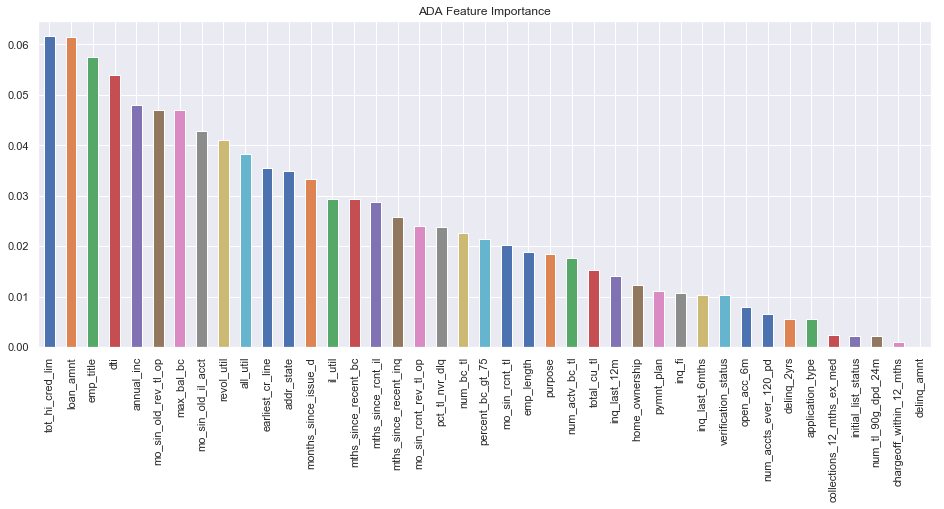

In [21]:
plt.figure(figsize=(16, 6))
plt.title('ADA Feature Importance')

feat_ada = pd.Series(
    ada_final.feature_importances_, index=X_train.columns)
feat_ada.nlargest(41).plot(kind='bar')

In [22]:
# The top ten features that will be used in the unsupervised learning notebook
feat_ada.nlargest(10)

tot_hi_cred_lim         0.061551
loan_amnt               0.061485
emp_title               0.057416
dti                     0.053985
annual_inc              0.047987
mo_sin_old_rev_tl_op    0.047041
max_bal_bc              0.046955
mo_sin_old_il_acct      0.042723
revol_util              0.040967
all_util                0.038344
dtype: float64

# XGB Evaluation 

    - ROC curve plot
    - confusion matrix
    - F1Score
    - Feature importance

In [23]:
xgb_final = XGBClassifier(max_depth=6,
                             n_estimators=8,
                             learning_rate=0.0125,
                             subsample=0.03,
                             colsample_bytree=0.5,
                             colsample_bylevel=0.5)
xgb_final.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.5,
       colsample_bytree=0.5, gamma=0, learning_rate=0.0125,
       max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
       n_estimators=8, n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.03)

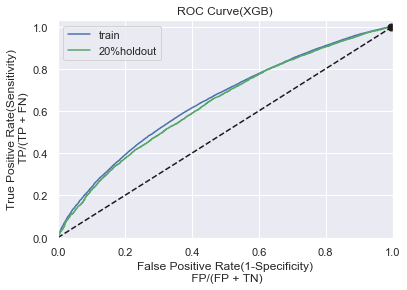

In [24]:
xgb_confmtx = confusion_matrix(y_test, xgb_final.predict(X_test))
tn1, fp1, fn1, tp1 = [i for i in xgb_confmtx.ravel()]


ypred_train = xgb_final.predict_proba(X_train)[:, 1]
ypred_test = xgb_final.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_train, ypred_train)
fpr1, tpr1, thresholds = roc_curve(y_test, ypred_test)
x1 = fp1/(fp1+tn1)
y1 = tp1/(tp1+fn1)
plt.plot(fpr, tpr, color='b')
plt.plot(fpr1, tpr1, color='g', label="20%holdout")
plt.plot(x1, y1, 'ko', markersize=7)
plt.legend(['train', '20%holdout'])
plt.title('ROC Curve(XGB)')
plt.xlabel('False Positive Rate(1-Specificity)\n FP/(FP + TN)')
plt.ylabel('True Positive Rate(Sensitivity)\n TP/(TP + FN)')
plt.xlim([0.0, 1])
plt.ylim([0.0, 1.03])
plt.grid(True)
plt.plot([0, 1], [0, 1], 'k--')
# plt.tight_layout()
plt.show()

As we saw with the accuracy score, XGB performs a little better than the baseline.  Which we can see in the ROC curve plot. The true postitives rate increases just as fast as the false positives.  This linear relationship is not a good model.

Precision:	0.7473
Recall:		0.9991
F1 Score:	0.8550


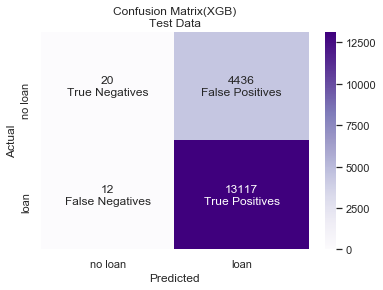

In [25]:
xbg_confmtx = confusion_matrix(y_test, xgb_final.predict(X_test))
tn1, fp1, fn1, tp1 = [i for i in xbg_confmtx.ravel()]
precision1 = tp1 / (tp1 + fp1)
recall1 = tp1 / (tp1 + fn1)
xgb_f1 = 2*(precision1 * recall1) / (precision1 + recall1)
print('Precision:\t{:.4f}\nRecall:\t\t{:.4f}\nF1 Score:\t{:.4f}'.format(
    precision1, recall1, xgb_f1))

# https://stackoverflow.com/questions/35572000/how-can-i-plot-a-confusion-matrix#51163585
# https://tatwan.github.io/How-To-Plot-A-Confusion-Matrix-In-Python/
plt.rcParams['font.size'] = 12
plt.subplot(111)
ax = sns.heatmap(xbg_confmtx, annot=True, cmap='Purples',
                 annot_kws={"size": 12}, fmt='g')
labels = ['True Negatives', 'False Positives',
          'False Negatives', 'True Positives']

for k, v in enumerate(ax.texts):
    v.set_text(v.get_text() + "\n" + labels[k])
plt.title('Confusion Matrix(XGB)\nTest Data')
ax.xaxis.set_ticklabels(['no loan', 'loan'])
ax.yaxis.set_ticklabels(['no loan', 'loan'])

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

_When using the cross validation the precision = 80.44% and Recall is 99.96% but when computing them via the confusion mattris the Precision is 78.65% and the Recall is 100%


`Precision = tp * tp+fp`

High precision means that an algorithm returned substantially more relevant results than irrelevant ones

`Recall = tp*tp+fn`

High recall means that an algorithm returned most of the relevant results.



---

___XGB Feture Importance___

In [26]:
xgb_fea_imp = pd.DataFrame(list(xgb_final.get_booster().get_fscore().items()),
                           columns=['feature', 'importance']).sort_values('importance', ascending=False)

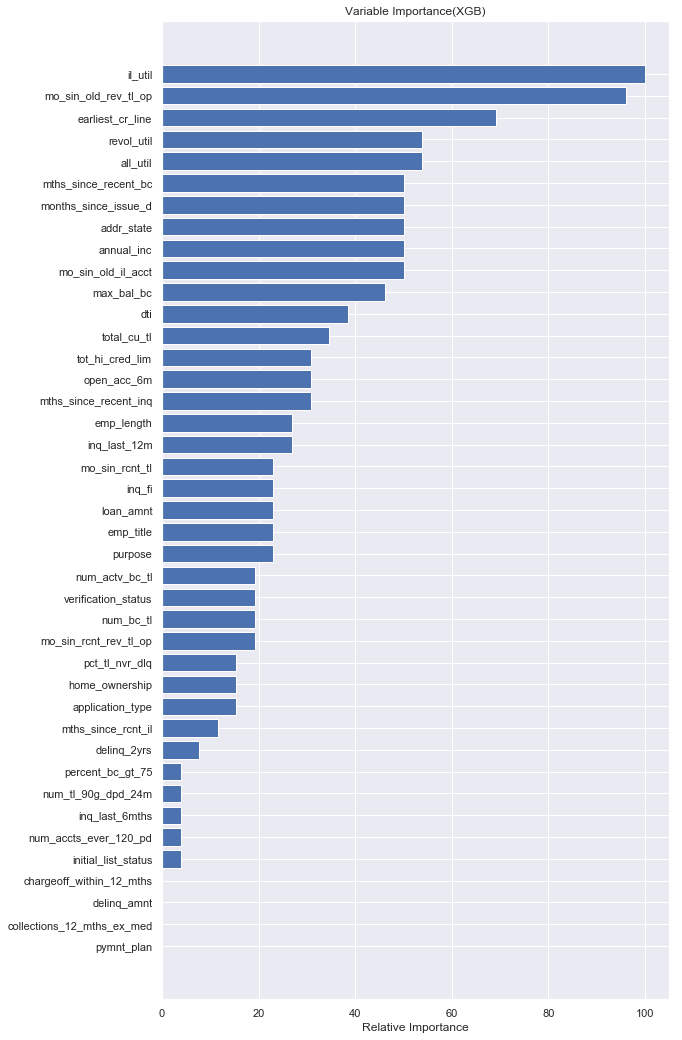

In [27]:
fig = plt.figure(figsize=(20, 18))
feature_importance = xgb_final.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance(XGB)')
plt.show()

So we now see there are only 5 significant features for XGB.  

# Conclusion
The RFC model is able to predict a good loan application `75%` of the time.  RFC mis-classified `41` good loan applications while ADA mis-classified `459` loans.  Overall, XGB did a poor job on predictions, it scored about the same as the baseline of`74.83%`  RFC and ADA were able to identify the positives(good loans) as seen with the recall score.

The models can be tuned more by dropping more of the features that don't even rank in feature importance such as `delinq_amnt`.  The XGB model was not a good choice for this model.  It didn't score above the baseline.  I think all models should be looked at again when the target variable is balanced to see if the score increases.  It would be beneficial to look at the outliers to see if it makes sense to remove some of them. I did try the SMOTE oversample and it didn't increase the accuracy, I would like to revisit the sampling and even try down sampling.

# Future Work

In [28]:
from sklearn.metrics import recall_score
weights = [1, 1.25, 1.5, 1.75, 2]
for x in weights:
    xgb_bal = XGBClassifier(max_depth=3,
                            n_estimators=8,
                            learning_rate=0.01,
                            subsample=0.001,
                            colsample_bytree=0.001,
                            colsample_bylevel=0.001,
                            scale_pos_weight=x)
    xgb_bal.fit(X_train, y_train)
    predictions = xgb_bal.predict(X_test)

    print('Weight of ', str(x))

    print('\nRecall Score:', recall_score(y_test, predictions))

    print('Accuracy Score:', accuracy_score(y_test, predictions))

    print('\nConfusion Matrix \n', confusion_matrix(y_test, predictions))
    print('---------------------------------')

Weight of  1

Recall Score: 1.0
Accuracy Score: 0.7466022177992607

Confusion Matrix 
 [[    0  4456]
 [    0 13129]]
---------------------------------
Weight of  1.25

Recall Score: 1.0
Accuracy Score: 0.7466022177992607

Confusion Matrix 
 [[    0  4456]
 [    0 13129]]
---------------------------------
Weight of  1.5

Recall Score: 1.0
Accuracy Score: 0.7466022177992607

Confusion Matrix 
 [[    0  4456]
 [    0 13129]]
---------------------------------
Weight of  1.75

Recall Score: 1.0
Accuracy Score: 0.7466022177992607

Confusion Matrix 
 [[    0  4456]
 [    0 13129]]
---------------------------------
Weight of  2

Recall Score: 1.0
Accuracy Score: 0.7466022177992607

Confusion Matrix 
 [[    0  4456]
 [    0 13129]]
---------------------------------
